In [17]:
import random
from sklearn.model_selection import ParameterGrid
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV
import joblib

/home/jiax1/.local/lib/python3.9/site-packages/xgboost/data.py:299: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/jiax1/.local/lib/python3.9/site-packages/xgboost/data.py:301: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/home/jiax1/.local/lib/python3.9/site-packages/xgboost/data.py:332: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/home/jiax1/.local/lib/python3.9/site-packages/xgboost/data.py:323: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dt

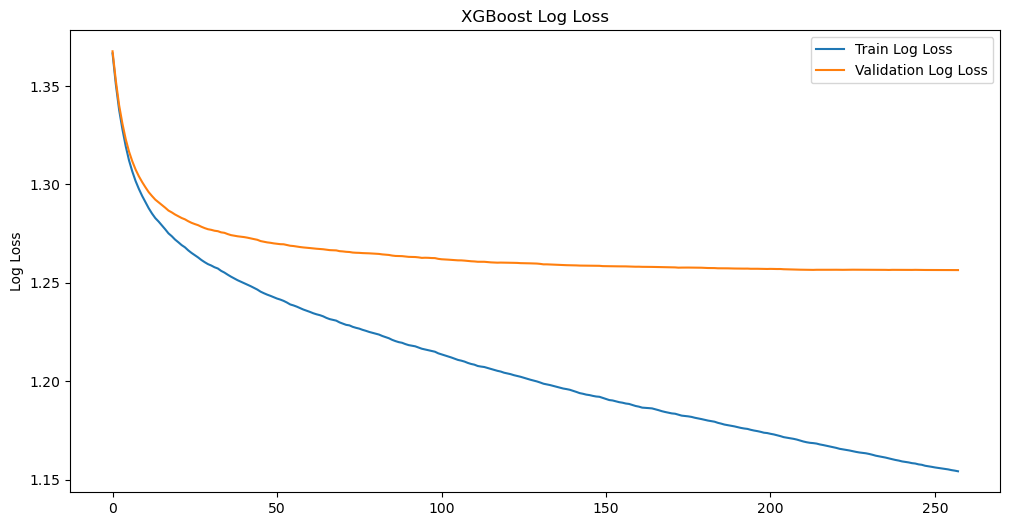

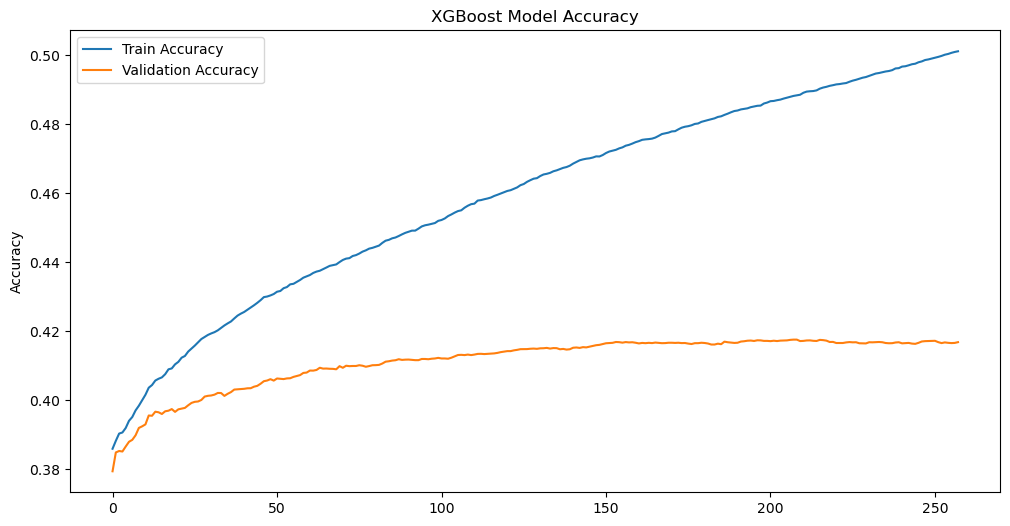

/home/jiax1/.local/lib/python3.9/site-packages/xgboost/data.py:299: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/jiax1/.local/lib/python3.9/site-packages/xgboost/data.py:301: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/home/jiax1/.local/lib/python3.9/site-packages/xgboost/data.py:332: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/home/jiax1/.local/lib/python3.9/site-packages/xgboost/data.py:323: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dt

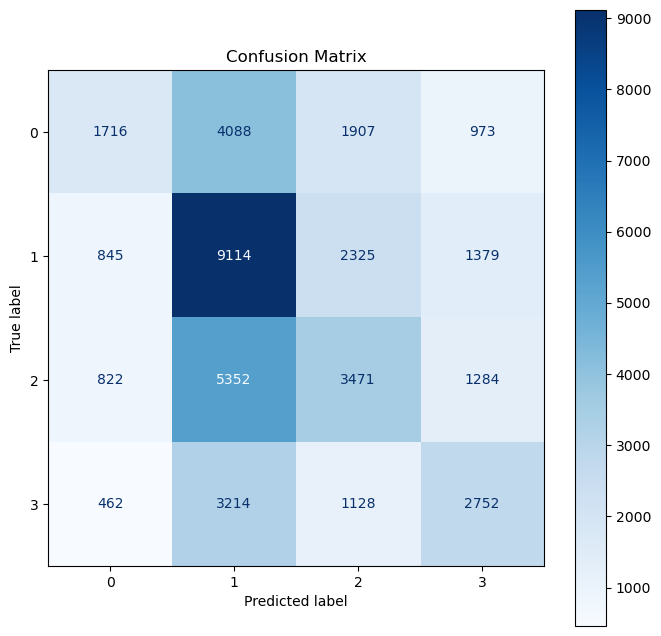

Hyperparameters: {'colsample_bylevel': 0.8, 'colsample_bytree': 0.9, 'learning_rate': 0.2, 'max_depth': 6, 'n_estimators': 400, 'subsample': 1}

Class-wise Metrics:
rush_morning - Precision: 0.45, Recall: 0.20, F1-Score: 0.27
rush_evening - Precision: 0.42, Recall: 0.67, F1-Score: 0.51
non_rush_day - Precision: 0.39, Recall: 0.32, F1-Score: 0.35
non_rush_night - Precision: 0.43, Recall: 0.36, F1-Score: 0.39

Macro Averages:
Precision: 0.42, Recall: 0.39, F1-Score: 0.38

Micro Averages:
Precision: 0.42, Recall: 0.42, F1-Score: 0.42


In [18]:
random.seed(42)
train_df = pd.read_csv('../03_Data_for_Modeling/train_xgboost.csv')
train_df = train_df.drop('most_common_time_window_4_neigh', axis=1)
X_train = train_df.drop(columns=['time_window'])
y_train = train_df['time_window']

valid_df = pd.read_csv('../03_Data_for_Modeling/val_xgboost.csv')
valid_df = valid_df.drop('most_common_time_window_4_neigh', axis=1)
X_valid = valid_df.drop(columns=['time_window'])
y_valid = valid_df['time_window']

test_df = pd.read_csv('../03_Data_for_Modeling/test_xgboost.csv')
test_df = test_df.drop('most_common_time_window_4_neigh', axis=1)
X_test = test_df.drop(columns=['time_window'])
y_test = test_df['time_window']

# Function to calculate and print metrics
def print_metrics(y_true, y_pred):
    class_names = ['rush_morning', 'rush_evening', 'non_rush_day', 'non_rush_night']
    precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, y_pred, average=None)

    print(f"\nClass-wise Metrics:")
    for i, class_name in enumerate(class_names):
        print(f"{class_name} - Precision: {precision[i]:.2f}, Recall: {recall[i]:.2f}, F1-Score: {f1_score[i]:.2f}")

    precision_macro, recall_macro, f1_score_macro, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
    precision_micro, recall_micro, f1_score_micro, _ = precision_recall_fscore_support(y_true, y_pred, average='micro')

    print("\nMacro Averages:")
    print(f"Precision: {precision_macro:.2f}, Recall: {recall_macro:.2f}, F1-Score: {f1_score_macro:.2f}")

    print("\nMicro Averages:")
    print(f"Precision: {precision_micro:.2f}, Recall: {recall_micro:.2f}, F1-Score: {f1_score_micro:.2f}")

params = {
    'colsample_bylevel': 0.8,
    'colsample_bytree': 0.9,
    'learning_rate': 0.2,
    'max_depth': 6,
    'n_estimators': 400,
    'subsample': 1
}
model = XGBClassifier(
    subsample=params['subsample'],
    n_estimators=params['n_estimators'],
    max_depth=params['max_depth'],
    learning_rate=params['learning_rate'],
    colsample_bytree=params['colsample_bytree'],
    colsample_bylevel=params['colsample_bylevel'],
    objective='multi:softmax',
    num_class=4,
    eval_metric=["mlogloss", "merror"],
    early_stopping_rounds=50
)

# Fit the model on the training data
eval_set = [(X_train, y_train), (X_valid, y_valid)]
model.fit(X_train, y_train, eval_set=eval_set, verbose=False)

# Get the results from the model
results = model.evals_result()
epochs = len(results['validation_0']['mlogloss'])
x_axis = range(0, epochs)

# Plot Log Loss
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(x_axis, results['validation_0']['mlogloss'], label='Train Log Loss')
ax.plot(x_axis, results['validation_1']['mlogloss'], label='Validation Log Loss')
ax.legend()
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.show()

# Plot Accuracy
train_accuracy = [1 - x for x in results['validation_0']['merror']]
validation_accuracy = [1 - x for x in results['validation_1']['merror']]
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(x_axis, train_accuracy, label='Train Accuracy')
ax.plot(x_axis, validation_accuracy, label='Validation Accuracy')
ax.legend()
plt.ylabel('Accuracy')
plt.title('XGBoost Model Accuracy')
plt.show()

# Generate and plot the confusion matrix
y_pred = model.predict(X_valid)
cm = confusion_matrix(y_valid, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.title('Confusion Matrix')
plt.show()

# Print hyperparameters
print("Hyperparameters:", params)

# Call print_metrics function
print_metrics(y_valid, y_pred)

/home/jiax1/.local/lib/python3.9/site-packages/xgboost/data.py:299: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/jiax1/.local/lib/python3.9/site-packages/xgboost/data.py:301: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/home/jiax1/.local/lib/python3.9/site-packages/xgboost/data.py:332: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/home/jiax1/.local/lib/python3.9/site-packages/xgboost/data.py:323: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dt

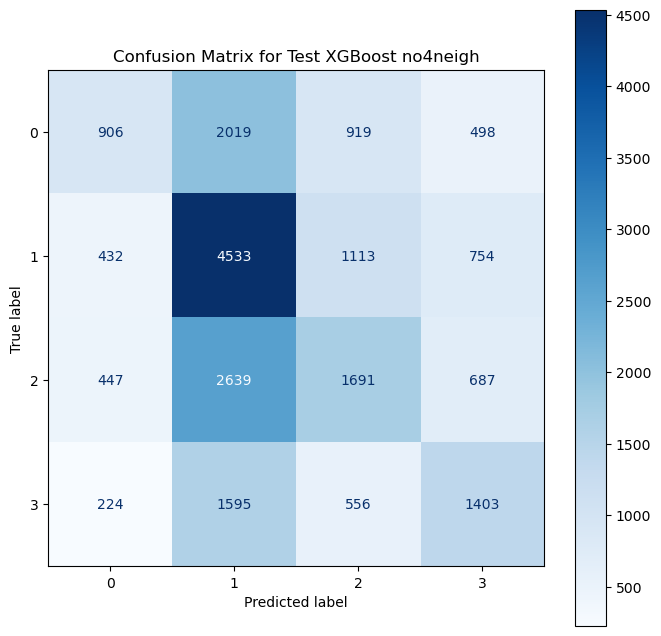

Hyperparameters: {'colsample_bylevel': 0.8, 'colsample_bytree': 0.9, 'learning_rate': 0.2, 'max_depth': 6, 'n_estimators': 400, 'subsample': 1}

Class-wise Metrics:
rush_morning - Precision: 0.45, Recall: 0.21, F1-Score: 0.29
rush_evening - Precision: 0.42, Recall: 0.66, F1-Score: 0.51
non_rush_day - Precision: 0.40, Recall: 0.31, F1-Score: 0.35
non_rush_night - Precision: 0.42, Recall: 0.37, F1-Score: 0.39

Macro Averages:
Precision: 0.42, Recall: 0.39, F1-Score: 0.39

Micro Averages:
Precision: 0.42, Recall: 0.42, F1-Score: 0.42


In [19]:
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.title('Confusion Matrix for Test XGBoost no4neigh')
plt.show()

# Print hyperparameters
print("Hyperparameters:", params)

# Call print_metrics function
print_metrics(y_test, y_pred)

In [20]:
val_probabilities = model.predict_proba(X_valid)

val_probabilities_df = pd.DataFrame(val_probabilities, columns=model.classes_)

val_probabilities_df.head(10)

/home/jiax1/.local/lib/python3.9/site-packages/xgboost/data.py:299: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/jiax1/.local/lib/python3.9/site-packages/xgboost/data.py:301: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/home/jiax1/.local/lib/python3.9/site-packages/xgboost/data.py:332: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/home/jiax1/.local/lib/python3.9/site-packages/xgboost/data.py:323: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dt

,0,1,2,3
0,0.224070,0.336780,0.342972,0.096179
1,0.152396,0.459546,0.276831,0.111226
2,0.132110,0.432413,0.248161,0.187316
3,0.085691,0.151864,0.339234,0.423212
4,0.062336,0.157192,0.087142,0.693330
5,0.075858,0.271011,0.393714,0.259417
6,0.205035,0.299255,0.304464,0.191246
7,0.104794,0.355316,0.201514,0.338376
8,0.227867,0.353624,0.211127,0.207382
9,0.481404,0.229769,0.136395,0.152431


In [21]:
test_probabilities = model.predict_proba(X_test)

test_probabilities_df = pd.DataFrame(test_probabilities, columns=model.classes_)

test_probabilities_df.head(10)

/home/jiax1/.local/lib/python3.9/site-packages/xgboost/data.py:299: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/jiax1/.local/lib/python3.9/site-packages/xgboost/data.py:301: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/home/jiax1/.local/lib/python3.9/site-packages/xgboost/data.py:332: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/home/jiax1/.local/lib/python3.9/site-packages/xgboost/data.py:323: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dt

,0,1,2,3
0,0.533512,0.238487,0.153704,0.074296
1,0.252036,0.264142,0.425297,0.058524
2,0.203484,0.305997,0.425350,0.065169
3,0.229706,0.359630,0.263821,0.146843
4,0.110669,0.103887,0.055952,0.729492
5,0.298559,0.351328,0.284020,0.066093
6,0.184561,0.399014,0.262197,0.154228
7,0.072123,0.439547,0.264847,0.223482
8,0.198743,0.253271,0.416543,0.131443
9,0.216420,0.332437,0.369996,0.081147


In [22]:
val_probabilities_df.to_csv("../03_Data_for_Modeling/val_xgboost_no4neigh_ensemble_probabilities.csv", index=False)
test_probabilities_df.to_csv("../03_Data_for_Modeling/test_xgboost_no4neigh_ensemble_probabilities.csv", index=False)